Import

In [16]:
import json, string, re
from collections import defaultdict
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict 
import nltk
import unicodedata
import pytz

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

config

In [106]:
cols = ['id', 'created_at', 'full_text', 'entities']
date_format = '%a %b %d %H:%M:%S %z %Y'
STOPWORDS = ['amp', 'u', 'U']
UTC=pytz.UTC

Prepare Variables

In [3]:
raw_data = json.load(open('data/realdonaldtrump.json', 'r'))
print('raw data imported')

raw_tweets = []
for tweet in raw_data:
    tweet = tweet['raw_data']
    row = {}
    for col in cols:
        row[col] = tweet[col]
    row['created_at'] = dt.strptime(row['created_at'], date_format)
    raw_tweets.append(row)
print('parsed raw data', len(raw_tweets))

tweets = pd.DataFrame(raw_tweets, columns=cols).sort_values('created_at')
print('loaded dataframe')

raw data imported
parsed raw data 47820
loaded dataframe


functions

In [116]:
def clean_str(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
        .encode('ascii', 'ignore')
        .decode('utf-8', 'ignore')
        .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

def get_range(df, since, until):
    since = UTC.localize(since)
    until = UTC.localize(until)
    return df.loc[(df['created_at']>=since)&(df['created_at']<=until)]

def plot_count_by_time(df):
    data = df['created_at'].apply(lambda ts: (ts+timedelta(hours=-5)).hour)
    sns.histplot(data=data)

def plot_used_words(df, amount, since=pd.Timestamp.min, until=pd.Timestamp.max):
    texts = get_range(df, since, until)['full_text'] #maybe .apply(lambda text: text.lower())
    count = []
    word_count = defaultdict(int)

    for text in texts:
        # get rid of links and usernames
        text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text)
        text = re.sub("(@[A-Za-z0-9_]+)","", text)
        # count words
        for word in clean_str(text):
            word_count[word] += 1

    #prepare for data frame
    for k, v in word_count.items():
        count.append({'word' : k, 'count' : v})
    #create df and plot
    df = pd.DataFrame(count, index=list(range(len(count)))).sort_values(by=['count'], ascending=False).head(amount)
    sns.barplot(data=df, x='word', y='count').set_xticklabels(rotation=90, labels=df['word'])

current playground

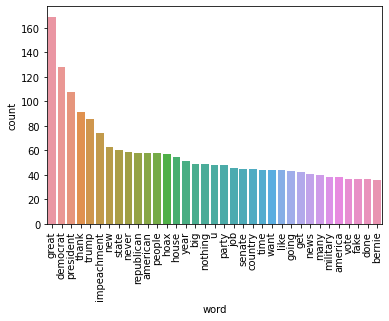

In [118]:
plot_used_words(tweets, 35, dt(2020,1,1), dt(2020,3,1))